In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
import pandas as pd
import torch
import numpy as np
import random
import re
import spacy
import shutil
import matplotlib.pyplot as plt
!pip install transformers
!pip install bertviz
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, BertTokenizer, AutoModel, BertModel
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, RandomSampler, SequentialSampler
import time
from scipy.stats import spearmanr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_root = '/content/drive/MyDrive/Tesis/SICK/uncase_based/SICK.txt'
with open(file_root, 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

In [ ]:
### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
### Read csv
cleaned_df = pd.read_csv(file_root, header=None, delimiter="\t", names=column_names)
len(cleaned_df)

9841

In [ ]:
def getSICKSents(filename='sts-train.csv', set_type='TRAIN', encoding='utf-8'):
  f = open(filename, 'r', encoding=encoding)
  s1, s2, target = [], [], []
  for i, line in enumerate(f):
    example = re.split(r'\t+', line)
    if i >= 1:
      if example[-1].strip() == set_type:
        s2.append(example[1])
        s1.append(example[2])
        target.append(float(example[4]))
  print("samples: {}".format(len(target)))
  return s1, s2, target

In [ ]:
s1_train,s2_train,target_train = getSICKSents(file_root, 'TRAIN')

samples: 4439


In [ ]:
s1_test,s2_test,target_test= getSICKSents(file_root, 'TEST')

samples: 4906


In [ ]:
s1_dev,s2_dev,target_dev= getSICKSents(file_root, 'TRIAL')

samples: 495


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [ ]:
BATCH_SIZE = 32
MAX_LEN = 128
CORPUS = 'STS-B'
BERT_PATH = "bert-base-uncased"
root_drive = '/content/drive/MyDrive/Tesis/SICK/transformer_tunned_BERT/uncase_base/'
MODEL_FILE_NAME = CORPUS+'_'+BERT_PATH+'_'+str(MAX_LEN)+'_tunned_model_sick.pt'

In [ ]:
TOKENIZER = BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

In [ ]:
def encode_sents(sents1, sents2):
    input_ids_ = []
    attention_masks_ = []
    type_ids_ = []
    for i, sent1 in enumerate(sents1):
        encoded_dict = TOKENIZER.encode_plus(
                            sent1,                      # Sentence 1 to encode.
                            sents2[i],                  # Sentence 2 to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            truncation = True,
                            max_length = MAX_LEN,       # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )

        # Add the encoded sentence to the list.
        input_ids_.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_.append(encoded_dict['attention_mask'])

        type_ids_.append(encoded_dict['token_type_ids'])
    return input_ids_, attention_masks_, type_ids_

In [ ]:
def getEncodedTensors(s1, s2, labels):
    input_ids, attention_masks, type_ids = encode_sents(s1, s2)
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    type_ids = torch.cat(type_ids, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, type_ids, labels

In [ ]:
input_ids_train,attention_masks_train,type_ids_train,labels_train = getEncodedTensors(s1_train,s2_train,target_train)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids_eval, attention_masks_eval, type_ids_eval, labels_eval = getEncodedTensors(s1_dev, s2_dev, target_dev)

In [ ]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, type_ids_train, labels_train)
val_dataset = TensorDataset(input_ids_eval, attention_masks_eval, type_ids_eval, labels_eval)

In [ ]:
# Create the DataLoaders for our training and test sets.
# We'll take training samples in random order.
torch.manual_seed(42)
train_loader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
            #num_workers=2
        )
torch.manual_seed(42)
val_loader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
            #num_workers=2
        )

In [ ]:
# See first batch
#batch = next(iter(train_loader))
#print(batch[0]) # 0 -> input_ids , 1 -> attention_masks, 2 -> type_ids, 3 -> targets
#print(train_loader.batch_size) #tamaño del batch
print('Number of train batches: {}'.format(len(train_loader)))# número de batches
print('Number of evaluation batches: {}'.format(len(val_loader)))

Number of train batches: 139
Number of evaluation batches: 16


In [ ]:
class BertBaseUncasedRegressor(nn.Module):
  def __init__(self, num_classes = 1, dropout=0.1, has_attentions=True, has_hidden_states = True, n_layers = 0):
      super().__init__()
      self.bert = BertModel.from_pretrained(BERT_PATH, output_attentions=has_attentions, output_hidden_states = has_hidden_states) #load the model
      # Return:
      # last_hidden_state.shape -> [batch_size, num_tokens_in_sequence,hidden_size] (bert_base hidden_size = 768)
      # pooler_output.shape -> [batch_size, hidden_size] se utiliza una capa de pooling simple que aplica una transformación
      # lineal seguida de una función de activación tangente hiperbólica (tanh) a la última representación oculta (last_hidden_state) del token [CLS].
      layers = []
      for _ in range(n_layers):
          layers.append(nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)) #self.bert.config.hidden_size -> nos da el tamaño oculto
          layers.append(nn.Dropout(dropout))
      layers.append(nn.Linear(self.bert.config.hidden_size, num_classes)) #self.bert.config.hidden_size -> nos da el tamaño oculto

      self.regressor = nn.Sequential(*layers)


  def forward(self, input_ids, type_ids, mask, layer_index_HS=12):
      bert_output =self.bert(input_ids=input_ids, token_type_ids = type_ids, attention_mask= mask)

      #output = bert_output.pooler_output
      if type(layer_index_HS) == str:
        output = bert_output.last_hidden_state[:, 0, :]
      else:
        output = bert_output.hidden_states[layer_index_HS][:, 0, :]
      logits = self.regressor(output)
      #logits = self.regressor(output_drop)
      return logits, bert_output

In [ ]:
model = BertBaseUncasedRegressor(n_layers = 2, dropout=0.20155960971087494).to(device)

In [ ]:
criterion = nn.MSELoss()
LEARNING_RATE = 2.67e-5 #2.45e-05 #3.36e-5
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def pearson_corr(y_pred, y_true):
    all_preds = np.concatenate(y_pred)
    all_targets = np.concatenate(y_true)
    return np.corrcoef(all_preds, all_targets)[0, 1]

In [ ]:
def spearman_corr(y_pred, y_true):
    all_preds = np.concatenate(y_pred)
    all_targets = np.concatenate(y_true)

    corr, _ = spearmanr(all_preds, all_targets)
    return corr

In [ ]:
def train_loop(model,loader,optimizer,criterion,device,layer_idx ='last_hidden_state',clip = 1.0):
    #Training loop
    model.train()
    loss_sum = 0
    all_preds = []
    all_targets = []
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    for i, batch in enumerate(loader):

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        optimizer.zero_grad()
        #Forward
        outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask, layer_index_HS=layer_idx)
        outputs = outputs.squeeze(-1)
        #Loss
        loss = criterion(outputs.view(-1), labels.float())
        #Backprop
        loss.backward()
        #prevent gradients from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #Update params
        optimizer.step()

        loss_sum += loss.item()

        all_preds.append(outputs.detach().cpu().numpy())
        all_targets.append(labels.float().detach().cpu().numpy())

    epoch_train_loss = loss_sum / len(loader)
    epoch_train_pearson = pearson_corr(all_preds, all_targets)
    epoch_train_spearman = spearman_corr(all_preds, all_targets)

    return epoch_train_loss, epoch_train_pearson, epoch_train_spearman


In [ ]:
def evaluation_loop(model,loader,criterion,device,layer_idx ='last_hidden_state'):
    #Evaluation loop
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    model.eval()
    with torch.no_grad():
        loss_sum = 0
        all_preds = []
        all_targets = []

        for i, batch in enumerate(loader):
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_type_ids = batch[2].to(device)
            labels = batch[3].to(device)

            #Forward
            outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask, layer_index_HS=layer_idx)
            outputs = outputs.squeeze(-1)
            #Loss
            loss = criterion(outputs.view(-1), labels.float())

            loss_sum += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_targets.append(labels.float().detach().cpu().numpy())

        epoch_dev_loss = loss_sum / len(loader)
        epoch_dev_pearson = pearson_corr(all_preds, all_targets)
        epoch_dev_spearman = spearman_corr(all_preds, all_targets)

    return epoch_dev_loss, epoch_dev_pearson, epoch_dev_spearman

In [ ]:
NUM_EPOCHS = 5
root_drive = '/content/drive/MyDrive/Tesis/SICK/transformer_tunned_BERT/uncase_base/'
best_valid_loss = float('inf')
MODEL_FILE_NAME = CORPUS+'_'+BERT_PATH+'_'+str(MAX_LEN)+'_tunned_model.pt'
history = {"train": {"loss": [],"pearson": [],'spearman':[]}, "val": {"loss": [],"pearson": [],'spearman':[]}}
layer_HS_idx = 12 # from 1 to 12 in the base model
torch.cuda.empty_cache()

seed = 78
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

for epoch in range(NUM_EPOCHS):

    start_time = time.time()

    epoch_train_loss, epoch_train_pearson, epoch_train_spearman = train_loop(model,train_loader,optimizer,criterion,device,layer_HS_idx)
    epoch_dev_loss, epoch_dev_pearson, epoch_dev_spearman = evaluation_loop(model,val_loader,criterion,device,layer_HS_idx)

    elapsed_time = time.time() - start_time

    #nos quedamos con el modelo que tiene mejor pérdida de validación
    if epoch_dev_loss < best_valid_loss:
      best_valid_loss = epoch_dev_loss
      torch.save(model.state_dict(), root_drive + MODEL_FILE_NAME)


    history["train"]["loss"].append(round(epoch_train_loss,4))
    history["val"]["loss"].append(round(epoch_dev_loss,4))
    history["train"]["pearson"].append(round(epoch_train_pearson,4))
    history["val"]["pearson"].append(round(epoch_dev_pearson,4))
    history["train"]["spearman"].append(round(epoch_train_spearman,4))
    history["val"]["spearman"].append(round(epoch_dev_spearman,4))

    print('-' * 80)
    print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Time: {elapsed_time:.4f}s | Train loss: {epoch_train_loss:.4f} | Dev loss: {epoch_dev_loss:.4f}')
    print(f'Train Pearson Coef: {epoch_train_pearson:.4f} | Dev Pearson Coef: {epoch_dev_pearson:.4f}')
    print(f'Train Spearman Coef: {epoch_train_spearman:.4f} | Dev Spearman Coef: {epoch_dev_spearman:.4f}')

--------------------------------------------------------------------------------
Epoch: 001/5 | Time: 91.4061s | Train loss: 0.6881 | Dev loss: 0.2727
Train Pearson Coef: 0.6615 | Dev Pearson Coef: 0.8708
Train Spearman Coef: 0.5833 | Dev Spearman Coef: 0.8303
--------------------------------------------------------------------------------
Epoch: 002/5 | Time: 93.8215s | Train loss: 0.2090 | Dev loss: 0.4781
Train Pearson Coef: 0.8966 | Dev Pearson Coef: 0.8836
Train Spearman Coef: 0.8468 | Dev Spearman Coef: 0.8402
--------------------------------------------------------------------------------
Epoch: 003/5 | Time: 94.3645s | Train loss: 0.1137 | Dev loss: 0.5047
Train Pearson Coef: 0.9450 | Dev Pearson Coef: 0.8820
Train Spearman Coef: 0.9174 | Dev Spearman Coef: 0.8395
--------------------------------------------------------------------------------
Epoch: 004/5 | Time: 93.5045s | Train loss: 0.0888 | Dev loss: 0.2982
Train Pearson Coef: 0.9575 | Dev Pearson Coef: 0.8887
Train Spearm

TEST

In [ ]:
model.load_state_dict(torch.load(root_drive + MODEL_FILE_NAME, map_location=torch.device(device)))
layer_HS_idx = 12
input_ids_test, attention_masks_test, type_ids_test, labels_test = getEncodedTensors(s1_test, s2_test, target_test)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, type_ids_test, labels_test)

torch.manual_seed(42)
test_iterator = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = BATCH_SIZE # Evaluate with this batch size.
                #num_workers=2
                )

test_loss, test_pearson, test_spearman = evaluation_loop(model,test_iterator,criterion,device,layer_HS_idx)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Pearson: {test_pearson:.3f}')
print(f'Test Spearman: {test_spearman:.3f}')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Test Loss: 0.212
Test Pearson: 0.890
Test Spearman: 0.834


In [ ]:
import gc
gc.collect()

153

In [ ]:
"""
# Crear DataFrame vacío
#df = pd.DataFrame()
df = pd.DataFrame({'layer_CLS': ['valor1']})

# Agregar columnas
df['layer_CLS'] = layer_HS_idx
df['train_loss'] = [history["train"]["loss"]]
df['val_loss'] = [history["val"]["loss"]]
df['train_pearson'] = [history["train"]["pearson"]]
df['val_pearson'] = [history["val"]["pearson"]]
df['train_spearman'] = [history["train"]["spearman"]]
df['val_spearman'] = [history["val"]["spearman"]]

df['test_loss'] = test_loss
df['test_pearson'] = test_pearson
df['test_spearman'] = test_spearman


# Imprimir DataFrame resultante
df
"""

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tesis/SICK/transformer_tunned_BERT/uncase_base/CLS_layers2.csv')
df

In [ ]:
# Agregar filas
df = df.append({'layer_CLS': layer_HS_idx, 'train_loss': history["train"]["loss"], 'val_loss': history["val"]["loss"], 'train_pearson':history["train"]["pearson"], 'val_pearson': history["val"]["pearson"],'train_spearman':history["train"]["spearman"], 'val_spearman':history["val"]["spearman"],'test_loss':test_loss,'test_pearson':test_pearson,'test_spearman': test_spearman}, ignore_index=True)
df

In [ ]:
df.to_csv('/content/drive/MyDrive/Tesis/STS_Benchmark/transformer_tunned_BERT/uncase_base/CLS_layers2.csv', index=False)
df

In [ ]:
test = list(zip(s1_test,s2_test,target_test))

In [ ]:
def similarity_test(test_dataset, num_example, model, device, layer_idx):

    sents1, sents2, targets = zip(*test_dataset)
    print("Sent 1: ", sents1[num_example])
    print("Sent 2: ", sents2[num_example])
    encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[num_example]], [sents2[num_example]])

    input_ids_test = torch.cat(encode_inputs, dim=0)
    attention_masks_test = torch.cat(encode_att_mask, dim=0)
    type_ids_test = torch.cat(encode_type, dim=0)
    labels_test = torch.tensor(targets[num_example])

    #ejecución de encoder con oración origen y máscara origen
    with torch.no_grad():
        output, bert = model(input_ids=input_ids_test.to(device),type_ids=type_ids_test.to(device),mask=attention_masks_test.to(device),layer_index_HS=layer_idx)
        output =output.squeeze(1)
        #attention
        # Obtener los pesos de atención para la primera capa de atención
        #attention_weights = bert.attentions[attention_layer]
    print("Predicted Class: ", round(output.item(),3))
    print("Target Class: ", round(labels_test.item(),3))
    return sents1[num_example], sents2[num_example], bert, input_ids_test


In [ ]:
def trim_attention(att, input_ids):
    # Obtener la longitud de la secuencia de entrada sin el relleno
    input_len = np.count_nonzero(input_ids != 0)

    # Recortar la atención para eliminar el relleno
    att_trimmed = att[:input_len, :input_len]

    # Normalizar la atención para que las filas sumen 1
    att_trimmed = att_trimmed / att_trimmed.sum(axis=-1, keepdims=True)
    return att_trimmed, input_len

In [ ]:
def view_attention(bert, input_ids, attention_layer):
    """
    Cuando se encuentra una palabra que no está en el vocabulario, el tokenizador de BERT la divide en
    subpalabras más pequeñas y agrega el prefijo "#" a cada subpalabra para indicar que es parte de la
     misma palabra original. Por ejemplo, la palabra "running" podría ser dividida en "run" y "##ning".
    """
    # Obtener los pesos de atención (batch_size, num_heads, sequence_length, sequence_length)
    batch_idx = 0 #always 0 for test a sequence
    num_head =0
    fig, axs = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axs.flat):
      attention = bert.attentions[attention_layer][batch_idx][i].cpu().detach().numpy()
      # Recortar la matriz de atención
      att_trimmed, sent_dim = trim_attention(attention, input_ids)
      sent = TOKENIZER.convert_ids_to_tokens(input_ids.squeeze().tolist())[:sent_dim]
      # Visualizar la matriz de atención recortada
      ax.matshow(att_trimmed, cmap='viridis')
      ax.set_title('Head ' + str(i+1))
      #axs[0].matshow(att_trimmed, cmap='hot')
      ax.set_xticks(np.arange(len(sent)), sent, rotation=90)
      ax.set_yticks(np.arange(len(sent)), sent)
      #plt.title('Atención del modelo BERT para dos oraciones')
    plt.tight_layout()
    plt.show()

In [ ]:
def save_attentions(test_dataset, model, device, layer_idx = 12):
    sents1, sents2, targets = zip(*test_dataset)
    all_attentions = {}
    dimensions = {}
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      #ejecución de encoder con oración origen y máscara origen
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)

      for attention_layer in range(12):
          for head in range(12):
              attention = bert.attentions[attention_layer][0][head].cpu().detach().numpy()
              # Recortar la matriz de atención
              att_trimmed, sent_dim = trim_attention(attention, input_ids)
              all_attentions[(i,attention_layer,head)] = {'vectors' : att_trimmed, 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
              dimensions[i] = sent_dim
    return all_attentions

In [ ]:
def save_outputs(test_dataset, model, device, layer_idx = 12): #save encoder outputs
    sents1, sents2, targets = zip(*test_dataset)
    hidden_states_outputs = {}
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      #ejecución de encoder con oración origen y máscara origen
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)
      for layer, hidden_state in enumerate(bert.hidden_states):
          if layer > 0 : #the first layer is embedding
            hidden_states_outputs[(i,layer)] = {'hidden_state' : hidden_state, 'label' : targets[i]} #all outputs have (1,128,768)
    return hidden_states_outputs

In [ ]:
def save_CLS_outputs(test_dataset, model, device, layer_idx = 12): #save encoder outputs
    sents1, sents2, targets = zip(*test_dataset)
    CLS_outputs_vectors, CLS_outputs = {}, {}
    sent_dim = 0
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      #ejecución de encoder con oración origen y máscara origen
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)

      for attention_layer in range(12):
          for head in range(12):
              attention = bert.attentions[attention_layer][0][head].cpu().detach().numpy()
              # Recortar la matriz de atención
              att_trimmed, sent_dim = trim_attention(attention, input_ids)

      for layer, hidden_state in enumerate(bert.hidden_states):
          if layer > 0 : #the first layer is embedding
            CLS_outputs_vectors[(i,layer-1)] = {'vectors' : hidden_state[:, 0, :], 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
            CLS_outputs[(i,layer-1)] = {'CLS_vectors' : hidden_state[:, 0, :], 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
    return CLS_outputs_vectors, CLS_outputs

In [ ]:
all_attentions = save_attentions(test, model, device)

In [ ]:
all_attentions[(1,5,5)]

{'vectors': array([[5.12910634e-03, 6.41188992e-04, 7.95902335e-04, ...,
         2.77143624e-03, 1.07339211e-01, 3.06085169e-01],
        [3.56531665e-02, 2.61110459e-02, 3.18743382e-03, ...,
         1.23049118e-04, 8.54500290e-03, 3.12170237e-01],
        [2.02286001e-02, 1.70440483e-03, 1.23200836e-02, ...,
         9.50533195e-06, 6.12535398e-04, 4.09687489e-01],
        ...,
        [1.34748500e-02, 2.44645980e-05, 2.69841195e-07, ...,
         5.28434627e-02, 3.26672532e-02, 3.34347308e-01],
        [4.56446130e-03, 3.80151978e-05, 4.89344302e-06, ...,
         2.50332337e-03, 3.72937173e-02, 4.03672010e-01],
        [4.99396585e-03, 1.13792645e-04, 4.53391476e-05, ...,
         1.13769755e-04, 1.53475767e-03, 4.45627183e-01]], dtype=float32),
 'sequence': 's1: The young boys are playing outdoors and the man is smiling nearby s2: A group of boys in a yard is playing and a man is standing in the background',
 'label': 3.7,
 'dimension': 32}

In [ ]:
#forma alternativa a .pth para guardar datos pesados
"""
with h5py.File('all_attentions_sick.h5', 'w') as hf:
    for key, value in all_attentions.items():
        group = hf.create_group(str(key))

        # Guardar el conjunto de datos 'vectors'
        group.create_dataset('vectors', data=value['vectors'])

        # Guardar el conjunto de datos 'sequence' como cadena
        group.create_dataset('sequence', data=np.string_(value['sequence']))

        # Guardar el conjunto de datos 'label'
        group.create_dataset('label', data=value['label'])

        # Guardar el conjunto de datos 'dimension'
        group.create_dataset('dimension', data=value['dimension'])
"""

In [ ]:
# Guardar el diccionario en un archivo
torch.save(all_attentions, root_drive + BERT_PATH + '_all_attentions_test_sick.pth', pickle_module=pickle_module)

In [ ]:
# Leer el diccionario desde el archivo
loaded_dict = torch.load(root_drive + BERT_PATH + '_all_attentions_test_sick.pth')

In [ ]:
loaded_dict[(0,6,5)]['attention'].shape # attention (example,layer,head)

In [ ]:
example = 621 #95, 71 raro #73 #548, #549 lo clasifico muy bien, #552 clasifico terriblemente
s1, s2, bert, inputs = similarity_test(test, example, model, device, 12)

Sent 1:  The dog is chasing the geese.
Sent 2:  One dog is chasing the other.

Predicted Class:  2.507
Target Class:  1.6


In [ ]:
#https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing#scrollTo=-QnRteSLP0Hm
def bertViz(test_dataset, num_example, view_type = 'head_view'):
    from bertviz import head_view, model_view
    from transformers import BertTokenizer, BertModel
    sents1, sents2, targets = zip(*test_dataset)
    print("Sent 1: ", sents1[num_example])
    print("Sent 2: ", sents2[num_example])
    inputs = TOKENIZER.encode_plus(sents1[num_example], sents2[num_example], return_tensors='pt')
    model1 = BertModel.from_pretrained(BERT_PATH, output_attentions=True)
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    attention = model1(input_ids, token_type_ids=token_type_ids)[-1]
    sentence_b_start = token_type_ids[0].tolist().index(1)
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = TOKENIZER.convert_ids_to_tokens(input_id_list)
    if view_type == 'head_view':
      head_view(attention, tokens, sentence_b_start)
    elif view_type == 'model_view':
      model_view(attention, tokens, sentence_b_start)
    else:
      from bertviz.neuron_view import show
      from bertviz.transformers_neuron_view import BertModel, BertTokenizer
      model2 = BertModel.from_pretrained(BERT_PATH, output_attentions=True)
      tokenizer = BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)
      show(model2, 'bert', tokenizer, sents1[num_example], sents2[num_example], layer=0, head=0)

In [ ]:
bertViz(test, example, 'model_view')

In [ ]:
inputs

tensor([[ 101, 1037, 2158, 2003, 4439, 1037, 2482, 1012,  102, 1037, 2158, 2003,
         5559, 1037, 3586, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
words = TOKENIZER.convert_ids_to_tokens(inputs.squeeze().tolist())

print(words)

['[CLS]', 'a', 'man', 'is', 'driving', 'a', 'car', '.', '[SEP]', 'a', 'man', 'is', 'riding', 'a', 'horse', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [ ]:
bert.attentions[11][0][0].shape

torch.Size([128, 128])

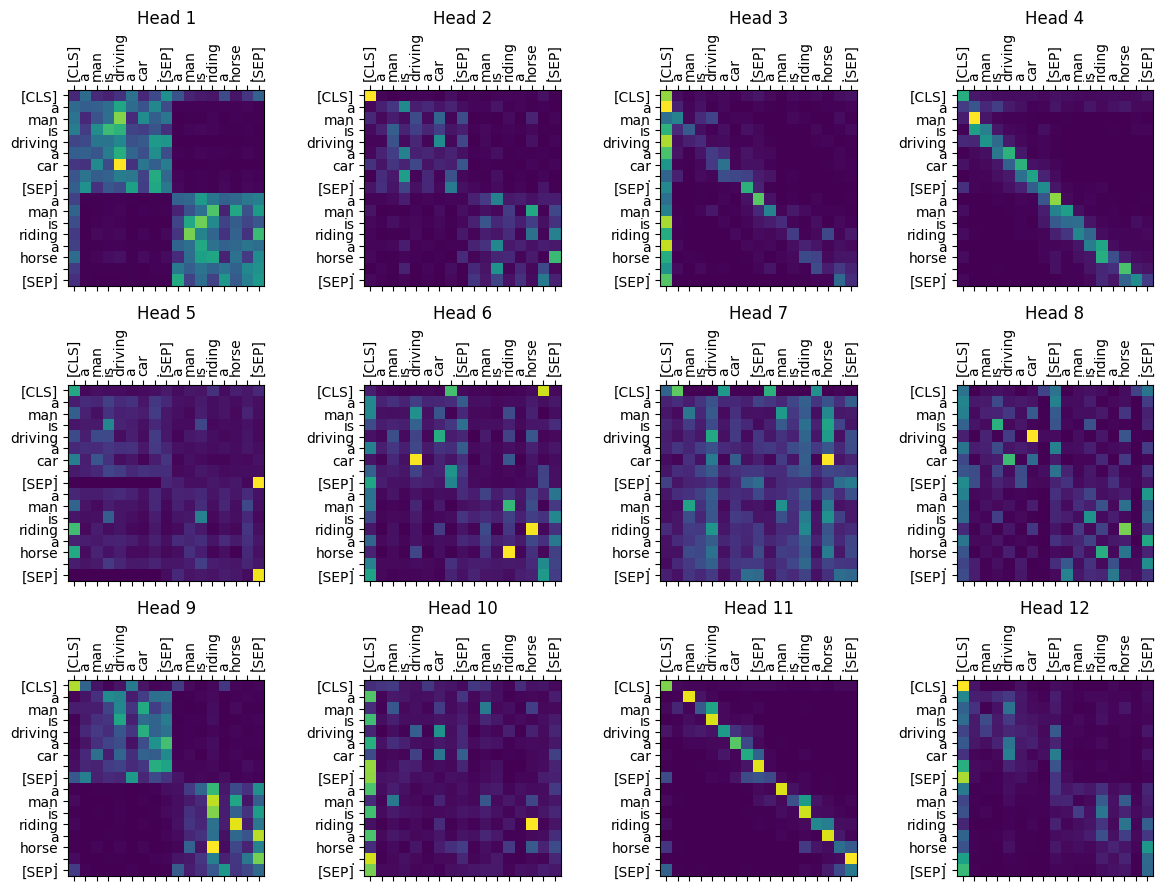

In [ ]:
view_attention(bert, inputs, 0)

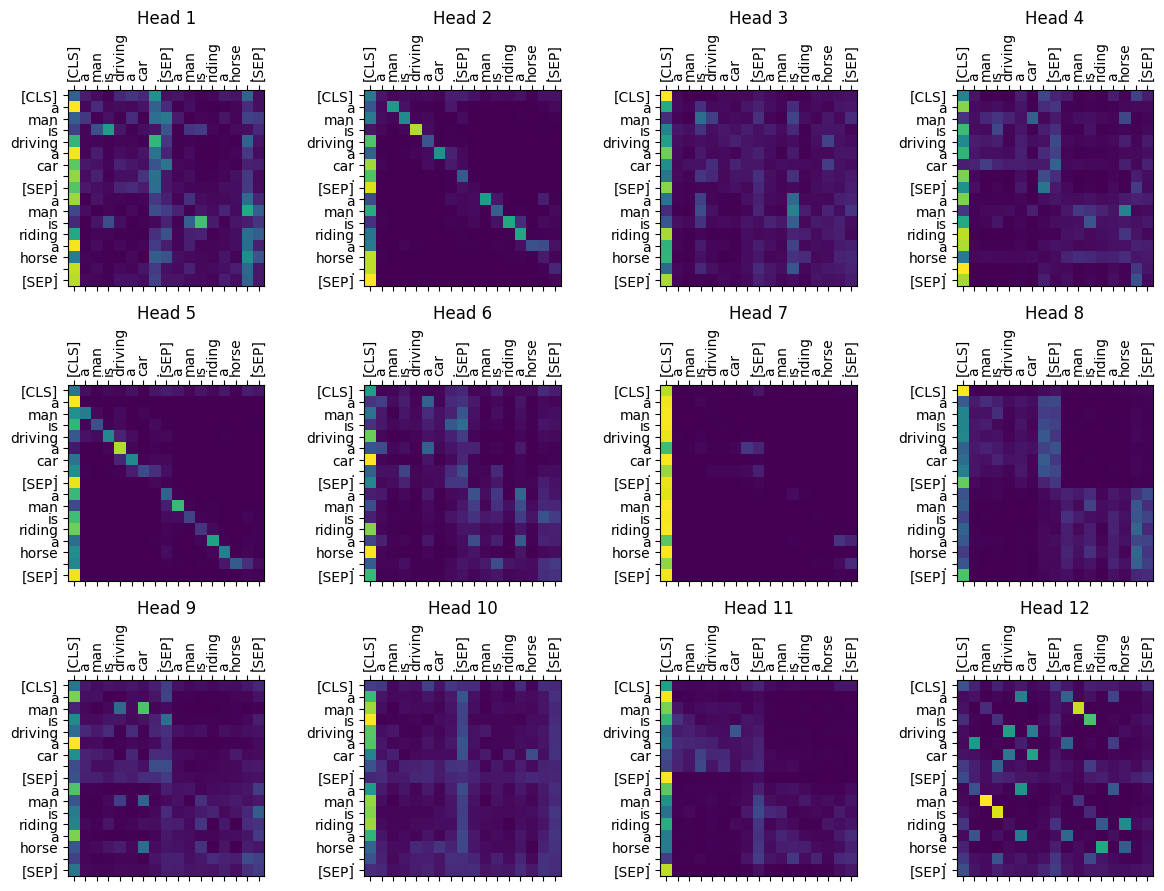

In [ ]:
view_attention(bert, inputs, 1)

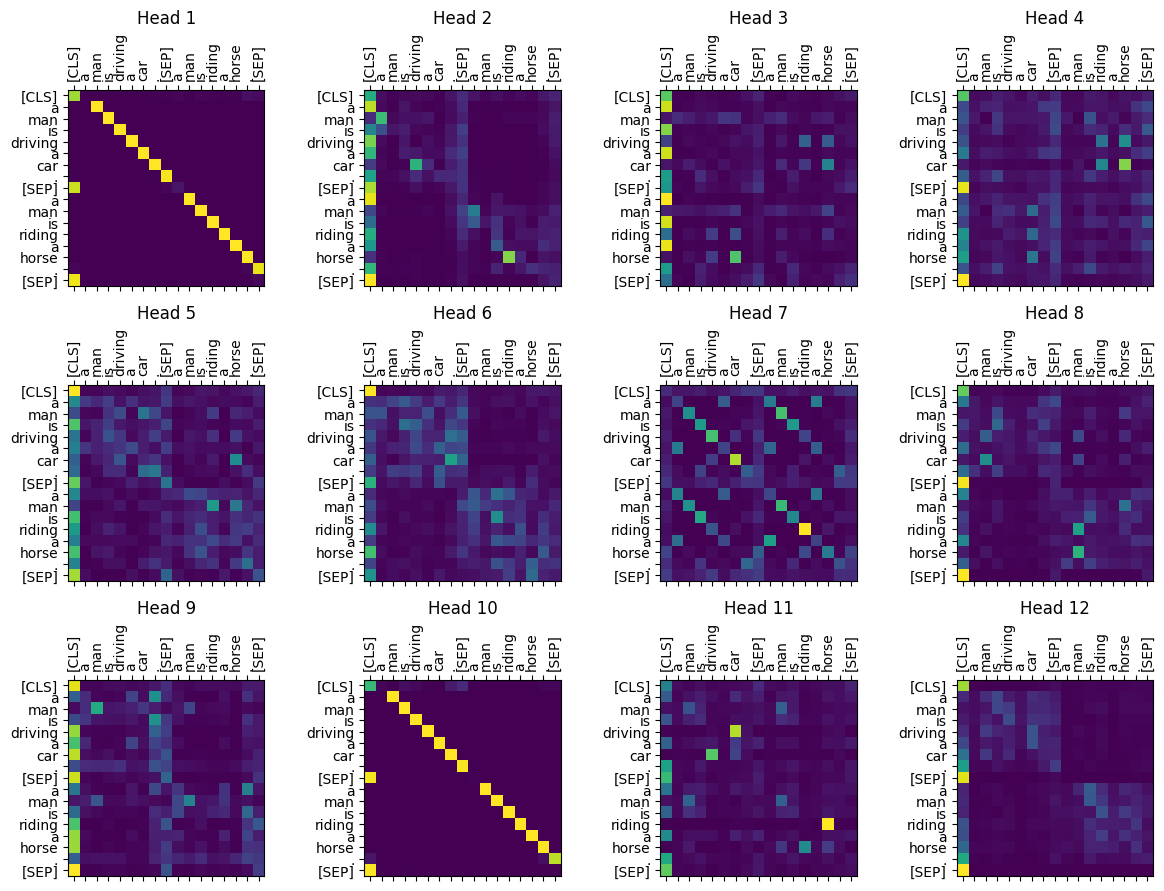

In [ ]:
view_attention(bert, inputs, 2)

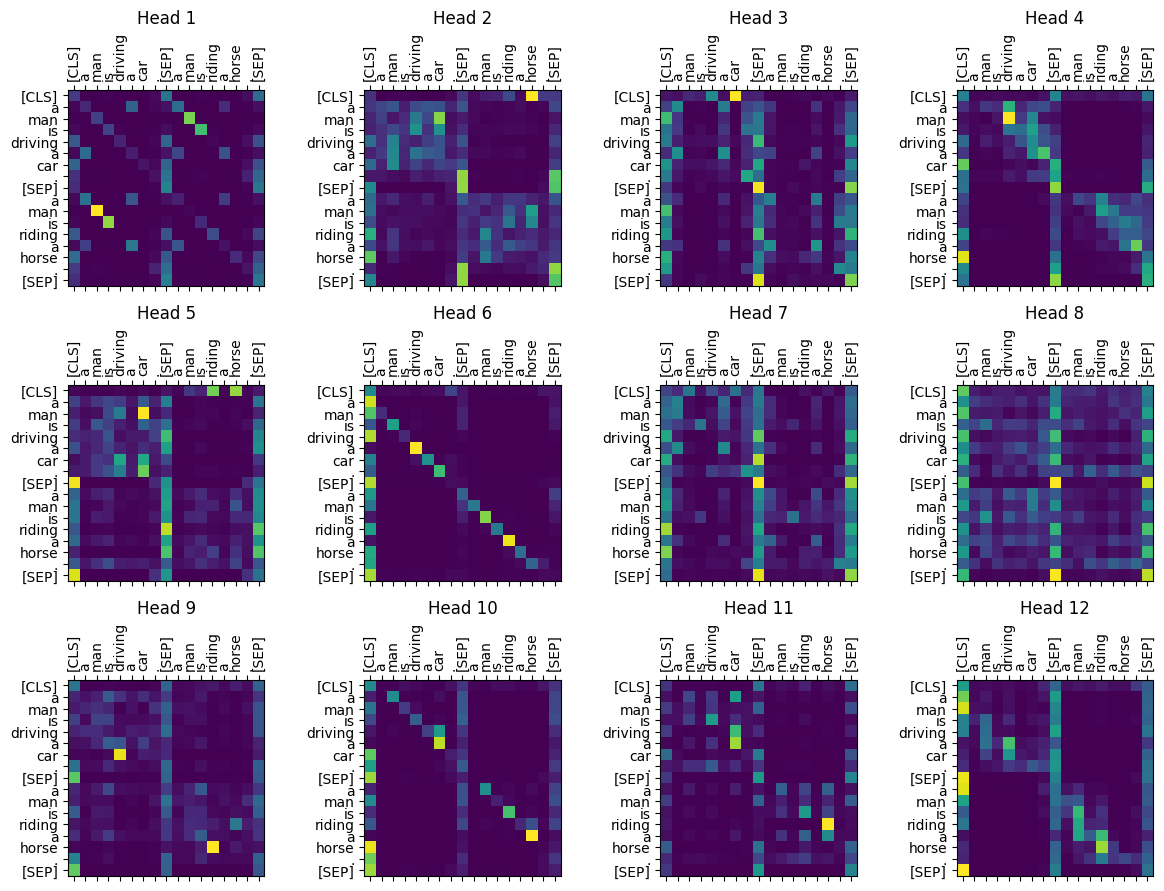

In [ ]:
view_attention(bert, inputs,3)

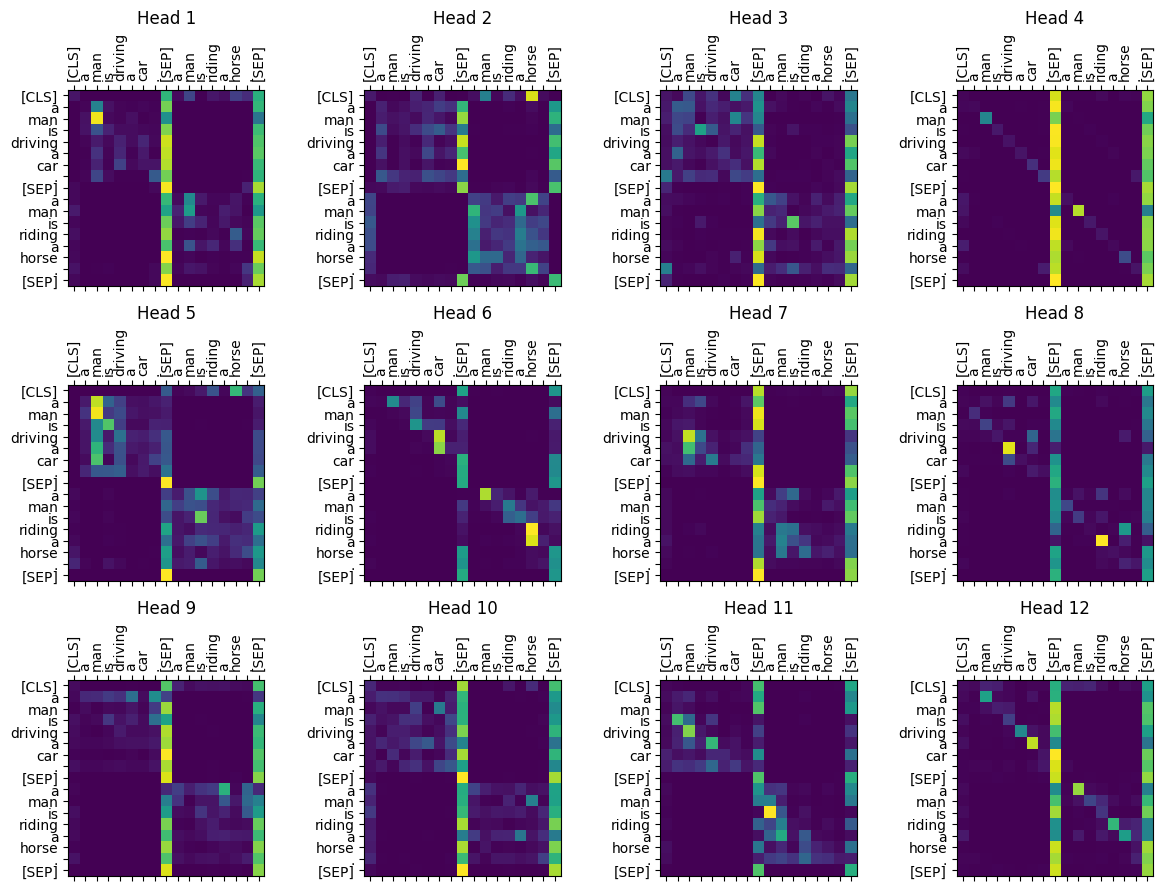

In [ ]:
view_attention(bert, inputs, 4)

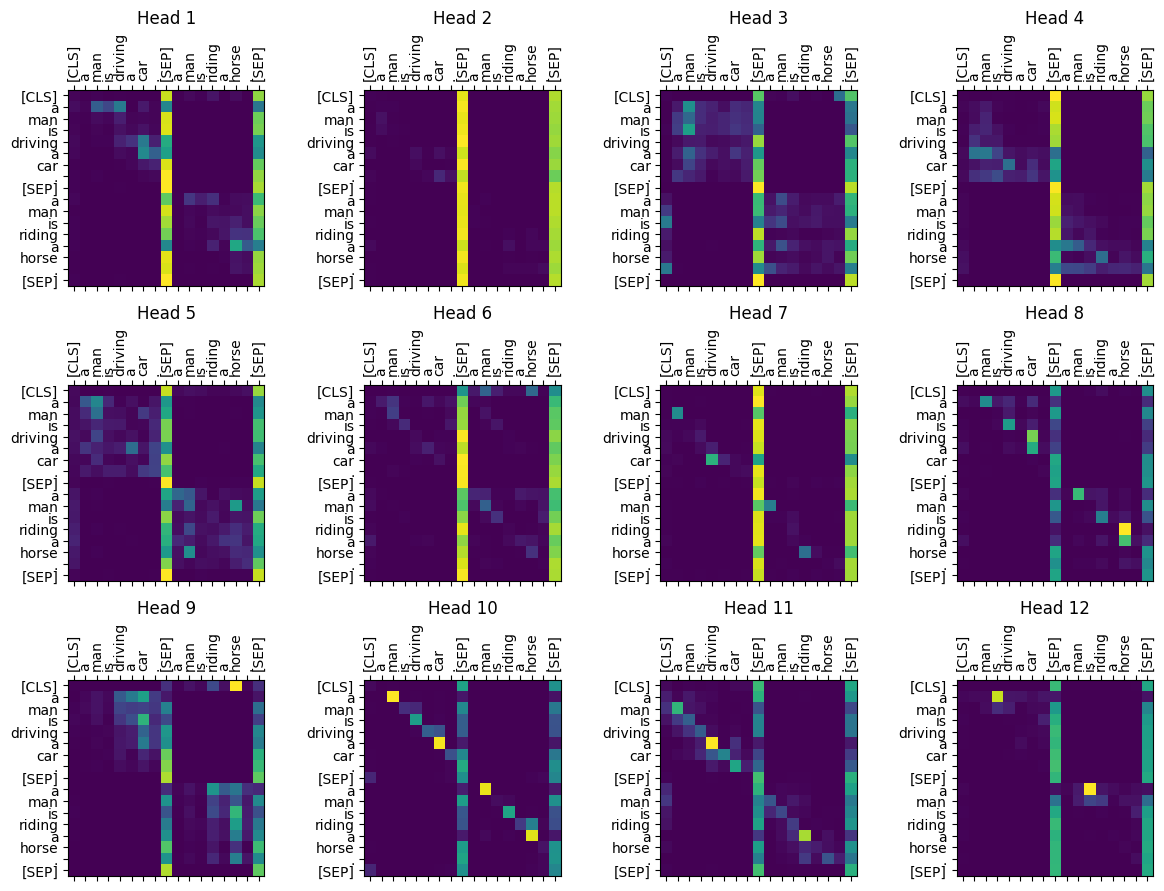

In [ ]:
view_attention(bert, inputs, 5)

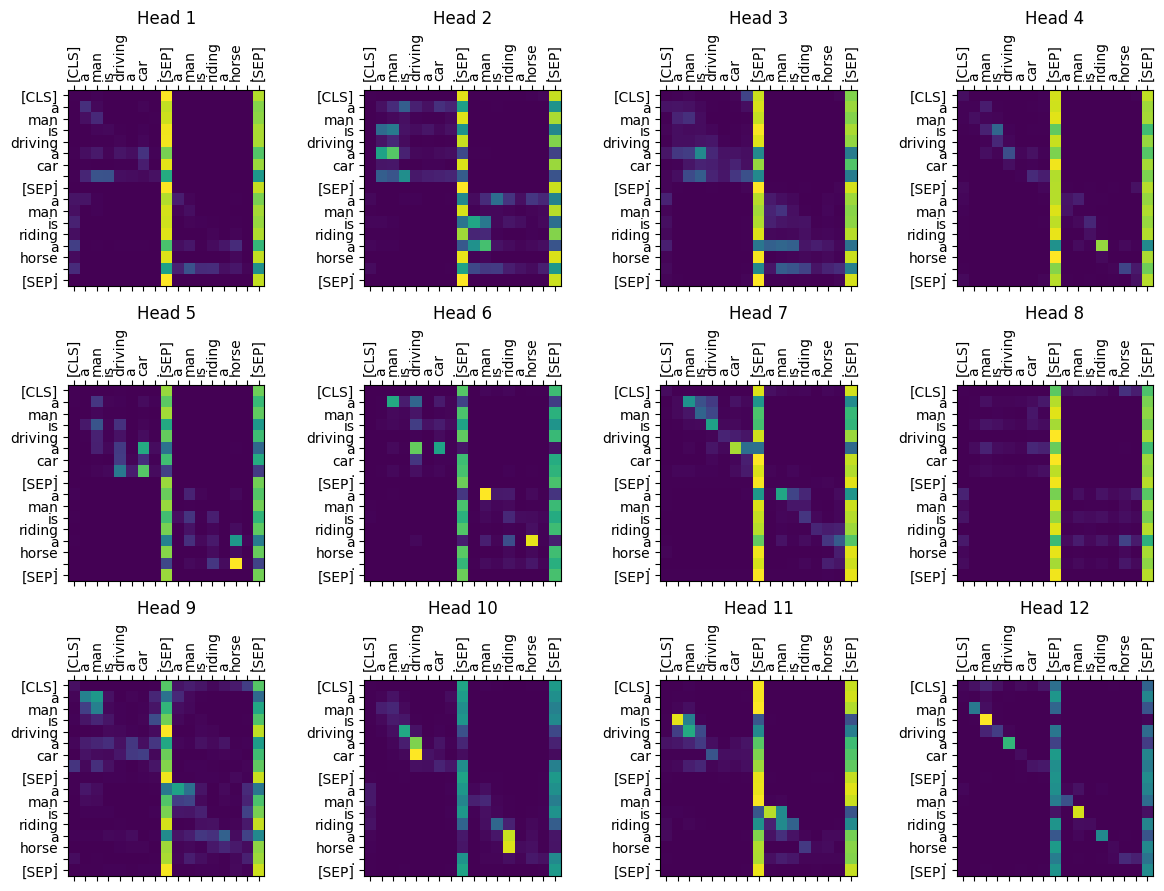

In [ ]:
view_attention(bert, inputs, 6)

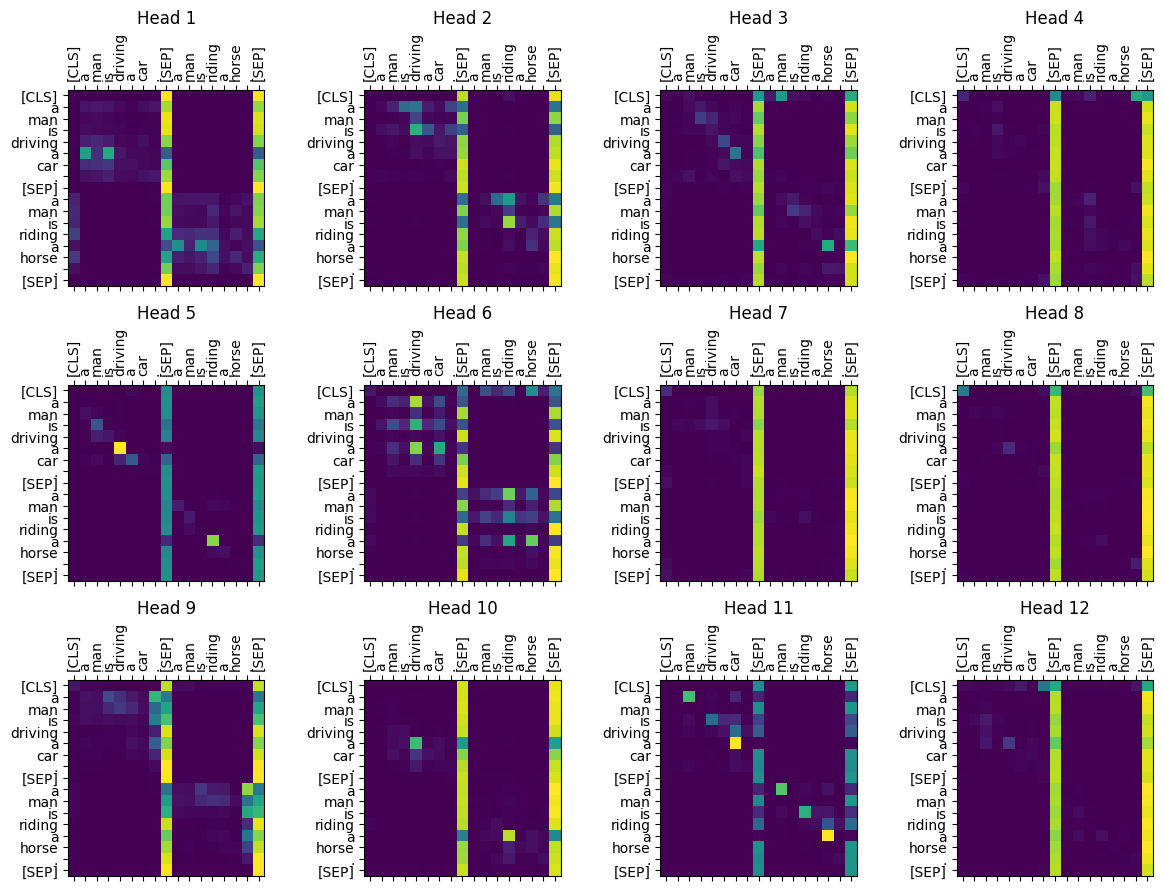

In [ ]:
view_attention(bert, inputs, 7)

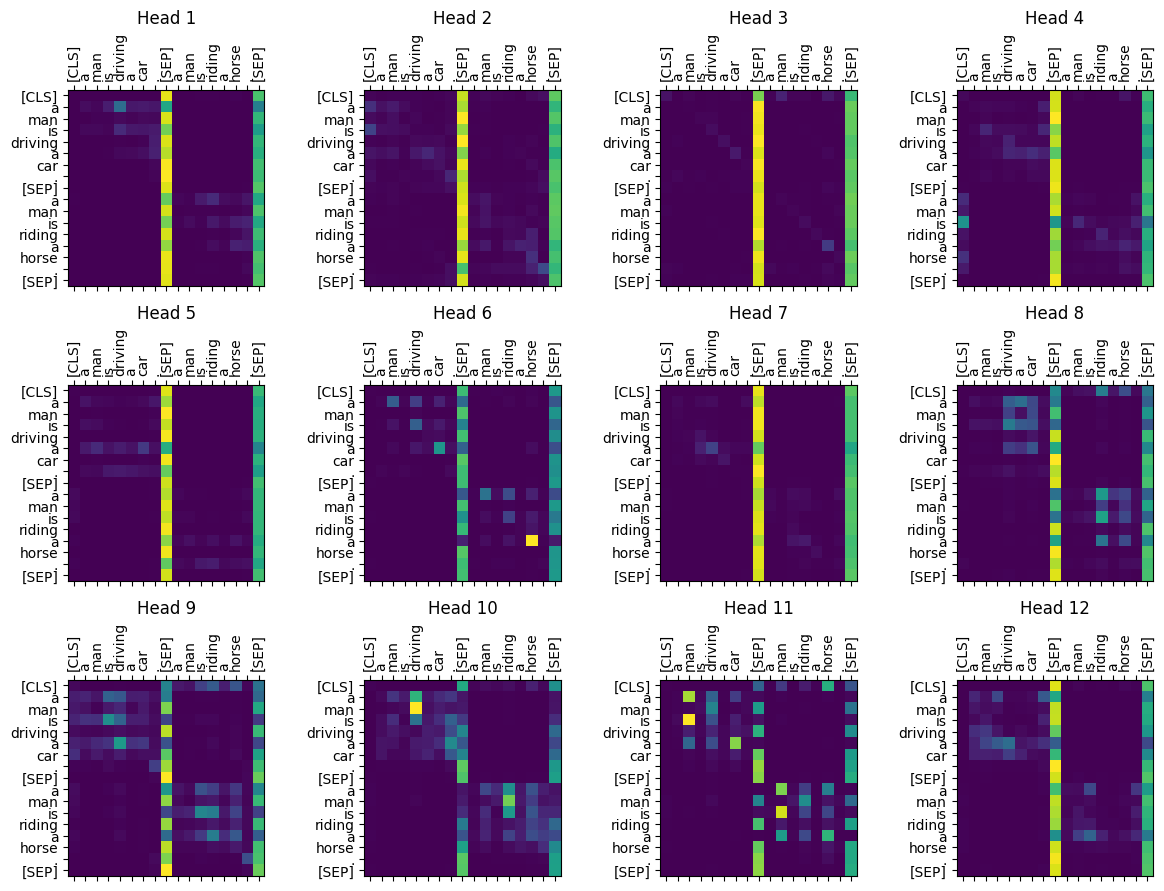

In [ ]:
view_attention(bert, inputs, 8)

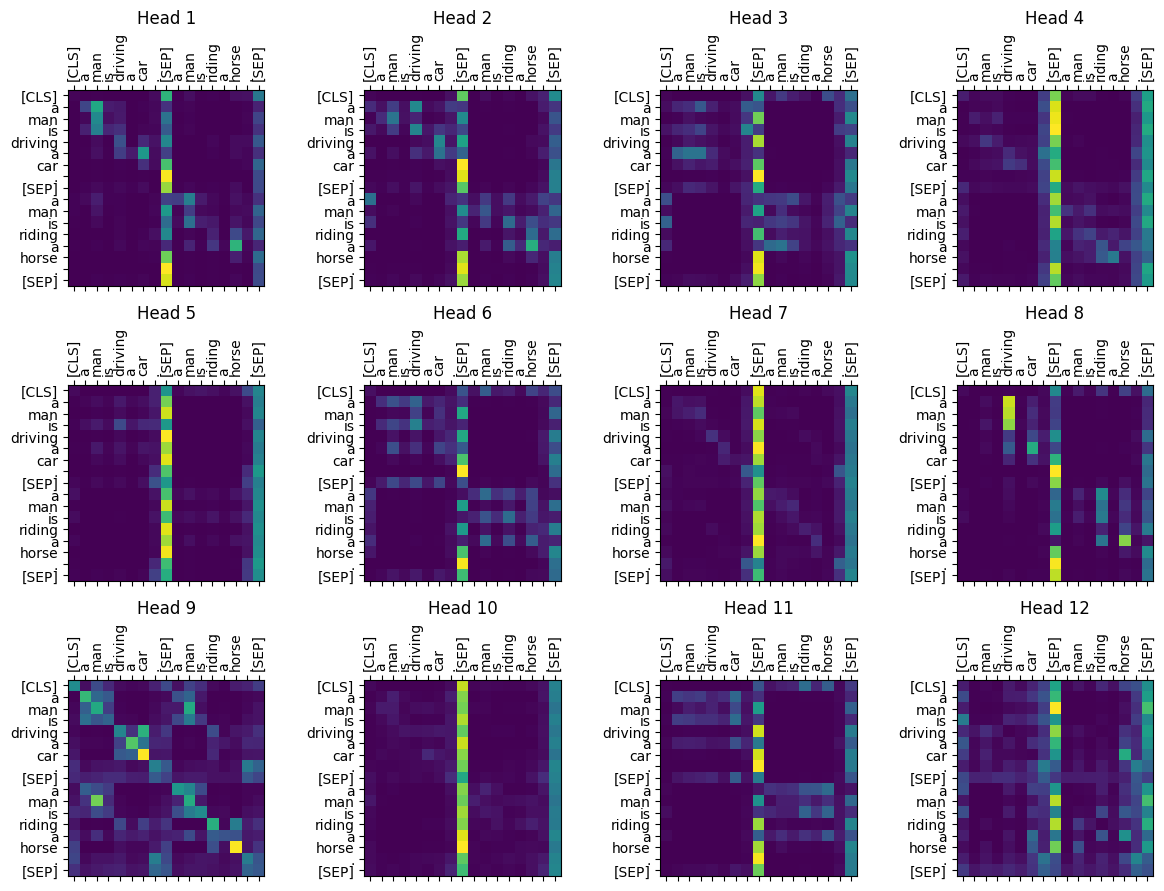

In [ ]:
view_attention(bert, inputs, 9)

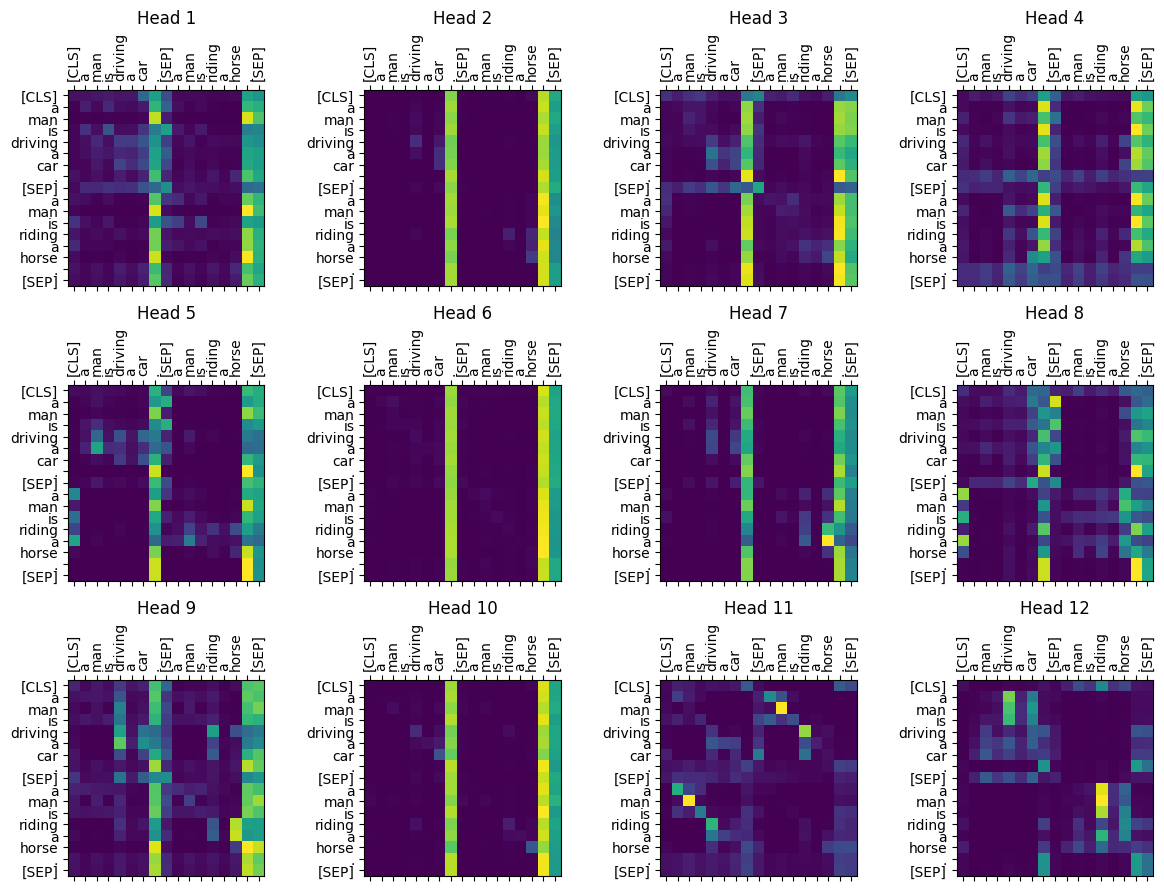

In [ ]:
view_attention(bert, inputs, 10)

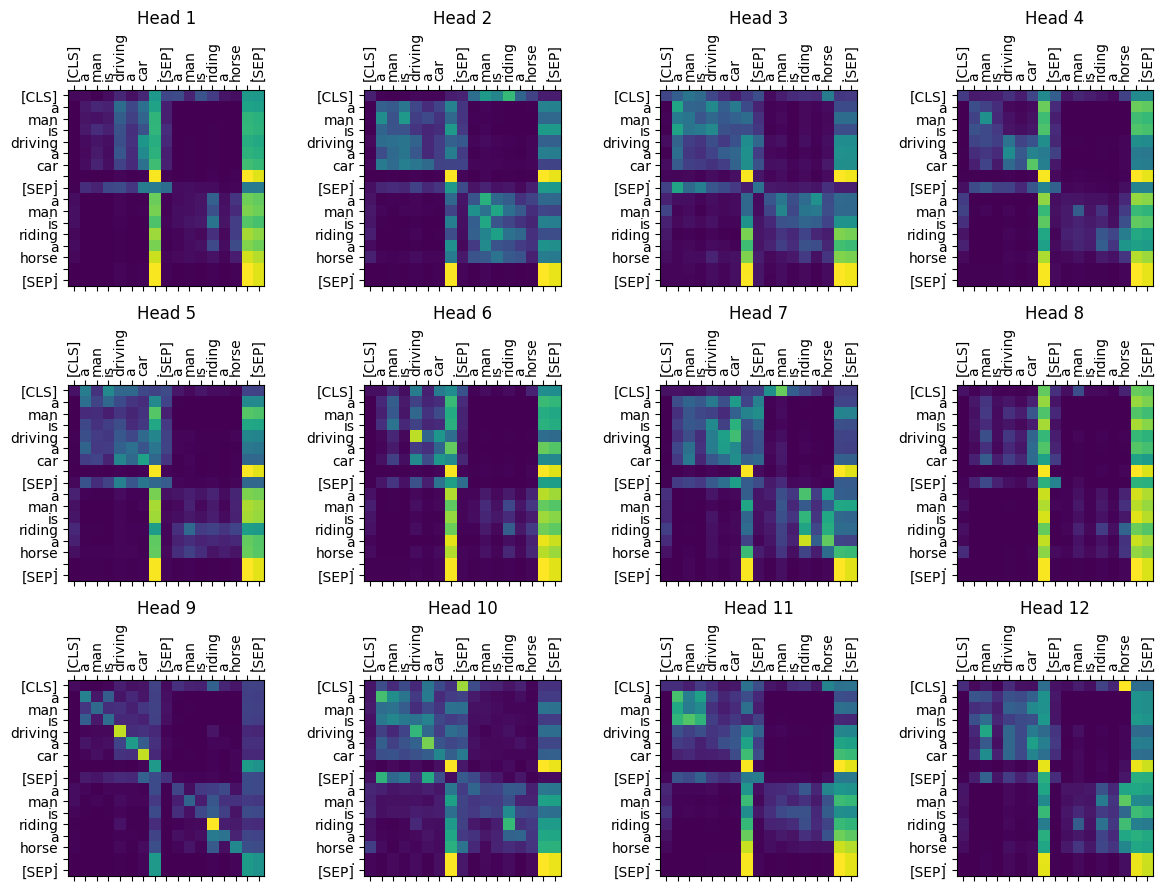

In [ ]:
view_attention(bert, inputs, 11)